<a href="https://colab.research.google.com/github/BenjamimOliveira/CN_TP1/blob/main/script/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN - CN - TP1
----------------
## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers
import time
import zipfile

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Mount google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data
 

In [3]:
start_time = time.time()
!cp -r 'drive/MyDrive/UMinho/CN/dataset.zip' 'dataset.zip'
print("%s segundos" % ((time.time() - start_time)))

14.901170492172241 segundos


In [4]:
start_time = time.time()
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_extr')
print("%s minutos" % ((time.time() - start_time)))

15.026281595230103 minutos


In [5]:
train_dir = '/content/dataset_extr/dataset/train'
test_dir = '/content/dataset_extr/dataset/test'
valid_dir = '/content/dataset_extr/dataset/valid'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(64, 64),
    batch_size=32)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(64, 64),
    batch_size=32)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    seed=123,
    image_size=(64, 64),
    batch_size=32)

Found 35215 files belonging to 250 classes.
Found 1250 files belonging to 250 classes.
Found 1250 files belonging to 250 classes.


In [6]:
class_names = train_ds.class_names

## Auto Tune


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN

In [ ]:
num_classes = 250

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 3)),
  layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilar o modelo

In [ ]:
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)
# Experimentar loss='sparse_categorical_crossentropy'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Treinar o modelo

In [ ]:
epochs=25
start_time = time.time()
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
  )
print("%s minutos" % ((time.time() - start_time)/60))

results = model.evaluate(test_ds)

Epoch 1/25
1101/1101 [==============================] - 37s 7ms/step - loss: 4.9876 - accuracy: 0.0503 - val_loss: 3.2254 - val_accuracy: 0.2632
Epoch 2/25
1101/1101 [==============================] - 4s 4ms/step - loss: 3.1095 - accuracy: 0.3015 - val_loss: 2.2732 - val_accuracy: 0.4600
Epoch 3/25
1101/1101 [==============================] - 4s 4ms/step - loss: 2.2453 - accuracy: 0.4691 - val_loss: 1.8495 - val_accuracy: 0.5408
Epoch 4/25
1101/1101 [==============================] - 4s 4ms/step - loss: 1.7584 - accuracy: 0.5700 - val_loss: 1.6736 - val_accuracy: 0.5872
Epoch 5/25
1101/1101 [==============================] - 4s 4ms/step - loss: 1.4382 - accuracy: 0.6391 - val_loss: 1.6529 - val_accuracy: 0.5928
Epoch 6/25
1101/1101 [==============================] - 4s 4ms/step - loss: 1.1876 - accuracy: 0.6912 - val_loss: 1.5662 - val_accuracy: 0.6272
Epoch 7/25
1101/1101 [==============================] - 4s 4ms/step - loss: 0.9410 - accuracy: 0.7530 - val_loss: 1.6782 - val_accuracy

## Prever

Em teoria o pássaro é um GREATOR SAGE GROUSE com 96.77 porcento de certeza mpt.


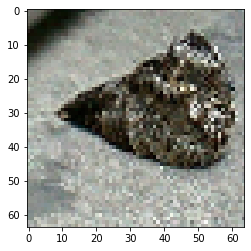

In [ ]:
i=4
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[i])

print(
    "Em teoria o pássaro é um {} com {:.2f} porcento de certeza mpt."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.imshow(list(test_ds)[0][0][i]/255)
plt.show()

## VGG 16/19


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = layers.Flatten(name="flatten")(top_model)
    #top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dense(1072, activation='relu')(top_model)
    #top_model = layers.Dropout(0.2)(top_model)
    output_layer = layers.Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = keras.Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

input_shape = (64,64,3)
optim_1 = optimizers.Adam(learning_rate=0.001)
n_classes=250

n_steps = 32
n_val_steps = 32
n_epochs = 15

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=1)





with tf.device('/device:GPU:0'):
  vgg_history = vgg_model.fit(train_ds,
                            epochs=n_epochs,
                            batch_size=32,
                            validation_data=valid_ds)

Epoch 1/15
1101/1101 [==============================] - 65s 19ms/step - loss: 9.9555 - accuracy: 0.0802 - val_loss: 3.7434 - val_accuracy: 0.2056
Epoch 2/15
1101/1101 [==============================] - 17s 16ms/step - loss: 3.6544 - accuracy: 0.2334 - val_loss: 3.3590 - val_accuracy: 0.2568
Epoch 3/15
1101/1101 [==============================] - 17s 16ms/step - loss: 3.0999 - accuracy: 0.3083 - val_loss: 3.3459 - val_accuracy: 0.2968
Epoch 4/15
1101/1101 [==============================] - 17s 16ms/step - loss: 2.7473 - accuracy: 0.3679 - val_loss: 3.3191 - val_accuracy: 0.3200
Epoch 5/15
1101/1101 [==============================] - 17s 15ms/step - loss: 2.5276 - accuracy: 0.4097 - val_loss: 3.5486 - val_accuracy: 0.3168
Epoch 6/15
1101/1101 [==============================] - 17s 16ms/step - loss: 2.3531 - accuracy: 0.4420 - val_loss: 3.5577 - val_accuracy: 0.3456
Epoch 7/15
1101/1101 [==============================] - 17s 16ms/step - loss: 2.1835 - accuracy: 0.4813 - val_loss: 3.6039 -

# Algoritmo Genético

In [ ]:
##
# Formato do gene [nParesConv2DMaxPooling(entre 1 e 3), learningRate, Momentum, Nesterov, lossFunction, batchSize, Epochs]
#
##

def random_pool_generator(poolSize=8):
  print(poolSize)

def select_mating_pool():
  pass

def crossover():
  pass

def mutation():
  pass



